In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import epsilon_0 as eps_0, mu_0
import jax
from jax import vmap, grad, jit
import jax.numpy as jnp
from jax.ops import index, index_update

from loader import load_antenna_el_properties
from misc import fig_config, rmse, mae
from nc_utils import (central_difference, holoborodko,
                      elementwise_quad as equad,
                      elementwise_dblquad as edblquad)

In [2]:
jax.config.update("jax_enable_x64", True)

In [3]:
%config InlineBackend.figure_format = 'retina'

# 1 Toy example

In [4]:
def f(x):
    return jnp.sin(jnp.sin(2 * x))

def df(x):
    return 2 * jnp.cos(2 * x) * jnp.cos(jnp.sin(2 * x))

def ddf(x):
    return - 4. * (jnp.sin(jnp.sin(2 * x)) * jnp.cos(2 * x) ** 2
                   + jnp.sin(2 * x) * jnp.cos(jnp.sin(2 * x)))


df_ad = vmap(grad(f))
ddf_ad = vmap(grad(grad(f)))


df_fd = central_difference(f, order=1)
ddf_fd = central_difference(f, order=2)

In [5]:
x = jnp.linspace(-1, 1, 21)
y = f(x)
dy = df(x)
dy_ad = df_ad(x)
dy_fd = df_fd(x)
ddy = ddf(x)
ddy_ad = ddf_ad(x)
ddy_fd = ddf_fd(x)

dy_ad_rmse = rmse(dy, dy_ad)
dy_fd_rmse = rmse(dy, dy_fd)
ddy_ad_rmse = rmse(ddy, ddy_ad)
ddy_fd_rmse = rmse(ddy, ddy_fd)

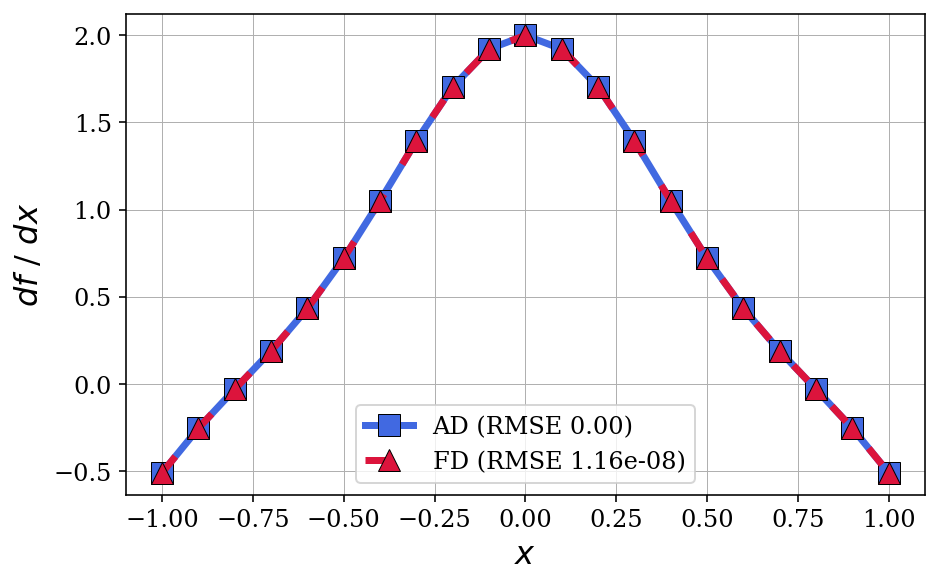

In [6]:
fig_config(scaler=1.5)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, dy_ad, 's-', color='royalblue',
        label=f'AD (RMSE {dy_ad_rmse:.2f})')
ax.plot(x, dy_fd, '^--', dashes=(3, 5), color='crimson',
        label=f'FD (RMSE {dy_fd_rmse:.2e})')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$df$ / $dx$')
ax.legend()
ax.grid()
plt.show()

In [7]:
fname = 'fig1a'
fig.savefig(os.path.join('figs', f'{fname}.pdf'),
            transparent=True,
            bbox_inches='tight', pad_inches=0.1)

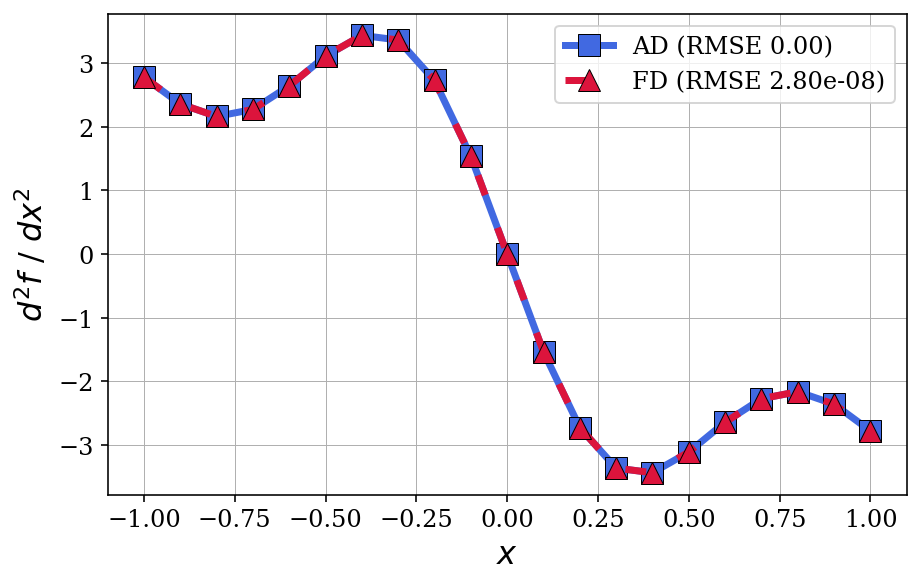

In [8]:
fig_config(scaler=1.5)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, ddy_ad, 's-', color='royalblue',
        label=f'AD (RMSE {ddy_ad_rmse:.2f})')
ax.plot(x, ddy_fd, '^--', dashes=(3, 5), color='crimson',
        label=f'FD (RMSE {ddy_fd_rmse:.2e})')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$d^2f$ / $dx^2$')
ax.legend()
ax.grid()
plt.show()

In [9]:
fname = 'fig1b'
fig.savefig(os.path.join('figs', f'{fname}.pdf'),
            transparent=True,
            bbox_inches='tight', pad_inches=0.1)

# 2 Working example

In [10]:
def green(xt, yt, zt, xs, ys, zs, omega):
    k = jnp.sqrt(omega ** 2 * eps_0 * mu_0)
    R = jnp.sqrt((xt - xs) ** 2 + (yt - ys) ** 2 + (zt - zs) ** 2)
    return jnp.exp(-1j * k * R) / R

green = jit(green)

In [11]:
# frequency
f = 10e9

# antenna electric properties (Poljak 2005)
antenna_data = load_antenna_el_properties(f)
Is = antenna_data.ireal.to_numpy() + antenna_data.iimag.to_numpy() * 1j
dx = antenna_data.x[1] - antenna_data.x[0]
Is_x = holoborodko(Is, dx)

# antenna position -- coordinates
xs = antenna_data.x.to_numpy()
xs = np.asarray(xs)
ys = np.zeros_like(xs)
zs = np.zeros_like(xs)

# effective radiated skin area
target_area = (0.02, 0.02)  # 2 x 2 cm2
A = target_area[0] * target_area[1]
h = -5 / 1000  # distance from the antenna
N = [21, 21, 21]
xt = np.linspace(-target_area[0]/2, target_area[0]/2, N[0]) + xs[-1] / 2
yt = np.linspace(-target_area[1]/2, target_area[1]/2, N[1])
zt = np.array([h])

## 2.1 Central difference approach

In [12]:
def efield_fd(xt, yt, zt, xs, ys, zs, Is, Is_x, frequency, eps=1e-4):
    omega = 2 * np.pi * frequency
    gamma = 1j * np.sqrt(omega ** 2 * mu_0 * eps_0)
    prefix = 1 / (1j * 4 * np.pi * omega * eps_0)
    g = green(xt, yt, zt, xs, ys, zs, omega)
    g_x = central_difference(green, axis='x',
                             args=(yt, zt, xs, ys, zs, omega), eps=eps)(xt)
    g_y = central_difference(green, axis='y',
                             args=(xt, zt, xs, ys, zs, omega), eps=eps)(yt)
    g_z = central_difference(green, axis='z',
                             args=(xt, yt, xs, ys, zs, omega), eps=eps)(zt)
    Ex = prefix * (- equad(Is_x * g_x, xs, 3)
                   - gamma ** 2 * equad(Is * g, xs, 3))
    Ey = prefix * (equad(Is_x * g_y, xs, 3))
    Ez = prefix * (equad(Is_x * g_z, xs, 3))
    return (Ex, Ey, Ez)


def hfield_fd(xt, yt, zt, xs, ys, zs, Is, frequency, eps=1e-4):
    omega = 2 * np.pi * frequency
    prefix = 1 / (4 * np.pi)
    g_y = central_difference(green, axis='y',
                             args=(xt, zt, xs, ys, zs, omega), eps=eps)(yt)
    g_z = central_difference(green, axis='z',
                             args=(xt, yt, xs, ys, zs, omega), eps=eps)(zt)
    Hy = prefix * equad(Is * g_z, xs, 3)
    Hz = - prefix * equad(Is * g_y, xs, 3)
    Hx = np.zeros_like(Hz)
    return (Hx, Hy, Hz)

In [13]:
Ex_fd = np.empty((xt.size, yt.size, zt.size), dtype=np.complex128)
Ey_fd = np.empty((xt.size, yt.size, zt.size), dtype=np.complex128)
Ez_fd = np.empty((xt.size, yt.size, zt.size), dtype=np.complex128)
Hx_fd = np.empty((xt.size, yt.size, zt.size), dtype=np.complex128)
Hy_fd = np.empty((xt.size, yt.size, zt.size), dtype=np.complex128)
Hz_fd = np.empty((xt.size, yt.size, zt.size), dtype=np.complex128)
for x_idx, _xt in enumerate(xt):
    for y_idx, _yt in enumerate(yt):
        for z_idx, _zt in enumerate(zt):
            _ex, _ey, _ez = efield_fd(_xt, _yt, _zt, xs, ys, zs, Is, Is_x, f)
            _hx, _hy, _hz = hfield_fd(_xt, _yt, _zt, xs, ys, zs, Is, f)
            Ex_fd[x_idx, y_idx, z_idx] = _ex
            Ey_fd[x_idx, y_idx, z_idx] = _ey
            Ez_fd[x_idx, y_idx, z_idx] = _ez
            Hx_fd[x_idx, y_idx, z_idx] = _hx
            Hy_fd[x_idx, y_idx, z_idx] = _hy
            Hz_fd[x_idx, y_idx, z_idx] = _hz

In [14]:
I0m_fd = np.sqrt(np.power(Ex_fd * Hy_fd.conj(), 2)) 
I0_fd = np.real(I0m_fd)
IPD_fd = 1 / (2 * A) * edblquad(I0_fd, xt, yt, 31)

## 2.2 Automatic differentiation approach

In [15]:
# conversion
xs = jnp.asarray(xs)
ys = jnp.asarray(ys)
zs = jnp.asarray(zs)
xt = jnp.asarray(xt)
yt = jnp.asarray(yt)
zt = jnp.asarray(zt)
Is = jnp.asarray(Is)
Is_x = jnp.asarray(Is_x)

In [16]:
green_grad = jit(vmap(
    grad(green, argnums=(0, 1, 2), holomorphic=True),
    in_axes=(None, None, None, 0, 0, 0, None)))


def efield_ad(xt, yt, zt, xs, ys, zs, Is, Is_x, frequency):
    omega = 2 * jnp.pi * frequency
    gamma = 1j * jnp.sqrt(omega ** 2 * mu_0 * eps_0)
    prefix = 1 / (1j * 4 * jnp.pi * omega * eps_0)
    g = green(xt, yt, zt, xs, ys, zs, omega)
    g_x, g_y, g_z = green_grad(xt + 0j, yt + 0j, zt + 0j, xs, ys, zs, omega)
    Ex = prefix * (- equad(Is_x * g_x, xs, 3)
                   - gamma ** 2 * equad(Is * g, xs, 3))
    Ey = prefix * (equad(Is_x * g_y, xs, 3))
    Ez = prefix * (equad(Is_x * g_z, xs, 3))
    return (Ex, Ey, Ez)


def hfield_ad(xt, yt, zt, xs, ys, zs, Is, frequency):
    omega = 2 * jnp.pi * frequency
    prefix = 1 / (4 * jnp.pi)
    g_x, g_y, g_z = green_grad(xt + 0j, yt + 0j, zt + 0j, xs, ys, zs, omega)
    Hy = prefix * equad(Is * g_z, xs, 3)
    Hz = - prefix * equad(Is * g_y, xs, 3)
    Hx = np.zeros_like(Hz)
    return (Hx, Hy, Hz)

In [17]:
Ex_ad = np.empty((xt.size, yt.size, zt.size), dtype=jnp.complex128)
Ey_ad = np.empty((xt.size, yt.size, zt.size), dtype=jnp.complex128)
Ez_ad = np.empty((xt.size, yt.size, zt.size), dtype=jnp.complex128)
Hx_ad = np.empty((xt.size, yt.size, zt.size), dtype=jnp.complex128)
Hy_ad = np.empty((xt.size, yt.size, zt.size), dtype=jnp.complex128)
Hz_ad = np.empty((xt.size, yt.size, zt.size), dtype=jnp.complex128)
for x_idx, _xt in enumerate(xt):
    for y_idx, _yt in enumerate(yt):
        for z_idx, _zt in enumerate(zt):
            _ex, _ey, _ez = efield_ad(_xt, _yt, _zt, xs, ys, zs, Is, Is_x, f)
            _hx, _hy, _hz = hfield_ad(_xt, _yt, _zt, xs, ys, zs, Is, f)
            Ex_ad = index_update(Ex_ad, index[x_idx, y_idx, z_idx], _ex.item())
            Ey_ad = index_update(Ey_ad, index[x_idx, y_idx, z_idx], _ey.item())
            Ez_ad = index_update(Ez_ad, index[x_idx, y_idx, z_idx], _ez.item())
            Hx_ad = index_update(Hx_ad, index[x_idx, y_idx, z_idx], _hx.item())
            Hy_ad = index_update(Hy_ad, index[x_idx, y_idx, z_idx], _hy.item())
            Hz_ad = index_update(Hz_ad, index[x_idx, y_idx, z_idx], _hz.item())

In [18]:
I0m_ad = np.sqrt(np.power(Ex_ad * Hy_ad.conj(), 2)) 
I0_ad = np.real(I0m_ad)
IPD_ad = 1 / (2 * A) * edblquad(I0_ad, xt, yt, 31)

## 2.3 Evaluation

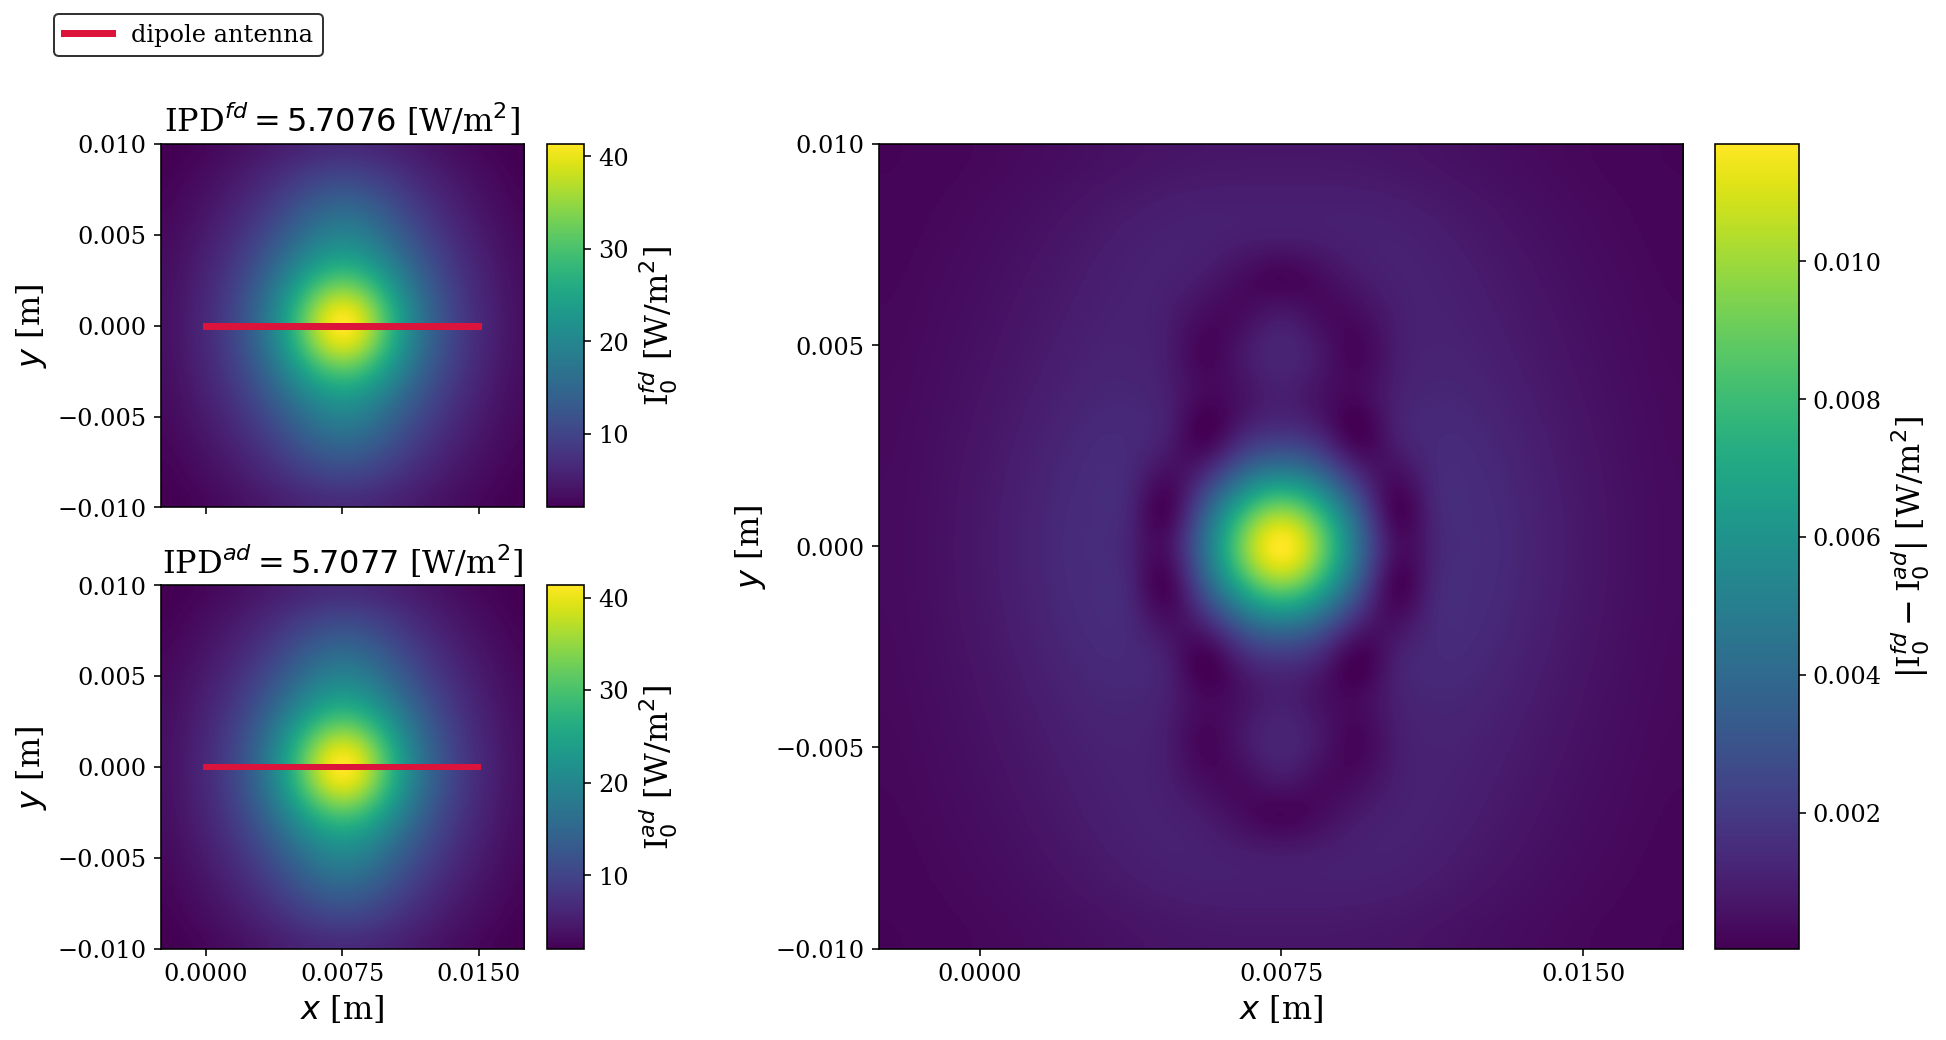

In [19]:
extent = (xt.min(), xt.max(), yt.min(), yt.max())
difference = np.abs(I0_fd - I0_ad)

fig_config(scaler=1.5)
fig = plt.figure(constrained_layout=True, figsize=(13.5, 6.5))
gs = fig.add_gridspec(nrows=2, ncols=3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax3 = fig.add_subplot(gs[0:, 1:])

cs1 = ax1.imshow(I0_fd, origin='lower', interpolation='spline36', extent=extent)
cbar1 = fig.colorbar(cs1, ax=ax1)
cbar1.ax.set_ylabel('I$_0^{fd}$ [W/m$^2$]')
ax1.plot(xs, ys, '-', color='crimson', label='dipole antenna')
ax1.set_title(f'IPD$^{{fd}} = {IPD_fd.item():.4f}$ [W/m$^2$]')
ax1.set_xticks([0.0, 0.0075, 0.015])
ax1.set_yticks([-0.01, -0.005, 0.0, 0.005, 0.01])
ax1.set_ylabel('$y$ [m]')

cs2 = ax2.imshow(I0_ad, origin='lower', interpolation='spline36', extent=extent)
cbar2 = fig.colorbar(cs2, ax=ax2)
cbar2.ax.set_ylabel('I$_0^{ad}$ [W/m$^2$]')
ax2.plot(xs, ys, '-', color='crimson', linewidth=3)
ax2.set_title(f'IPD$^{{ad}} = {IPD_ad.item():.4f}$ [W/m$^2$]')
ax2.set_xticks([0.0, 0.0075, 0.015])
ax2.set_yticks([-0.01, -0.005, 0.0, 0.005, 0.01])
ax2.set_xlabel('$x$ [m]')
ax2.set_ylabel('$y$ [m]')

cs3 = ax3.imshow(difference, origin='lower', interpolation='spline36', extent=extent)
cbar3 = fig.colorbar(cs3, ax=ax3)
cbar3.ax.set_ylabel('$|$I$_0^{fd} - $I$_0^{ad}|$ [W/m$^2$]')
ax3.set_xticks([0.0, 0.0075, 0.015])
ax3.set_yticks([-0.01, -0.005, 0.0, 0.005, 0.01])
ax3.set_xlabel('$x$ [m]')
ax3.set_ylabel('$y$ [m]')

fig.legend(bbox_to_anchor=(0.175, 1.1), frameon=True, edgecolor='k')
plt.setp(ax1.get_xticklabels(), visible=False)
plt.show()

In [20]:
fname = 'fig2'
fig.savefig(os.path.join('figs', f'{fname}.pdf'),
            transparent=True,
            bbox_inches='tight', pad_inches=0.1)

# 3 Comprehensive simulation

In [21]:
target_area = (0.02, 0.02)
A = target_area[0] * target_area[1]
d = -15 / 1000
N = [21, 21, 21]
f_list = [3., 6., 10., 15., 20., 30., 40., 60., 80., 100.]
eps_list = [1e-3, 0.5e-3, 1e-4]


def fd_sim(f, eps):
    antenna_data = load_antenna_el_properties(f)
    Is = antenna_data.ireal.to_numpy() + antenna_data.iimag.to_numpy() * 1j
    dx = antenna_data.x[1] - antenna_data.x[0]
    Is_x = holoborodko(Is, dx)
    xs = antenna_data.x.to_numpy()
    ys = np.zeros_like(xs)
    zs = np.zeros_like(xs)
    xt = np.linspace(-target_area[0]/2, target_area[0]/2, N[0]) + xs[-1] / 2
    yt = np.linspace(-target_area[1]/2, target_area[1]/2, N[1])
    zt = np.array([d])
    I0_fd = np.empty((xt.size, yt.size, zt.size))
    for x_idx, _xt in enumerate(xt):
        for y_idx, _yt in enumerate(yt):
            for z_idx, _zt in enumerate(zt):
                e = efield_fd(_xt, _yt, _zt, xs, ys, zs, Is, Is_x, f, eps)
                h = hfield_fd(_xt, _yt, _zt, xs, ys, zs, Is, f, eps)
                I0m_fd = np.sqrt(np.power(e[0] * h[1].conj(), 2))
                I0_fd[x_idx, y_idx, z_idx] = np.real(I0m_fd)
    return 1 / (2 * A) * edblquad(I0_fd, xt, yt, 31)


def ad_sim(f):
    antenna_data = load_antenna_el_properties(f)
    Is = antenna_data.ireal.to_numpy() + antenna_data.iimag.to_numpy() * 1j
    dx = antenna_data.x[1] - antenna_data.x[0]
    Is_x = holoborodko(Is, dx)
    xs = antenna_data.x.to_numpy()
    ys = np.zeros_like(xs)
    zs = np.zeros_like(xs)
    xs = jnp.asarray(xs)
    ys = jnp.asarray(ys)
    zs = jnp.asarray(zs)
    Is = jnp.asarray(Is)
    Is_x = jnp.asarray(Is_x)
    xt = jnp.linspace(-target_area[0]/2, target_area[0]/2, N[0]) + xs[-1] / 2
    yt = jnp.linspace(-target_area[1]/2, target_area[1]/2, N[1])
    zt = jnp.array([d])
    I0_ad = jnp.empty((xt.size, yt.size, zt.size))
    for x_idx, _xt in enumerate(xt):
        for y_idx, _yt in enumerate(yt):
            for z_idx, _zt in enumerate(zt):
                e = efield_ad(_xt, _yt, _zt, xs, ys, zs, Is, Is_x, f)
                h = hfield_ad(_xt, _yt, _zt, xs, ys, zs, Is, f)
                I0m_ad = jnp.sqrt(jnp.power(e[0] * h[1].conj(), 2)) 
                I0_ad = index_update(I0_ad, index[x_idx, y_idx, z_idx],
                                     jnp.real(I0m_ad))
    return 1 / (2 * A) * edblquad(I0_ad, xt, yt, 31)

In [22]:
IPD_ad_list = []
for f in f_list:
    IPD_ad_list.append(ad_sim(f * 1e9))

In [23]:
IPD_fd_dict = {}
for eps in eps_list:
    IPD_fd_list = []
    for f in f_list:
        IPD_fd_list.append(fd_sim(f * 1e9, eps))
        IPD_fd_dict[eps] = IPD_fd_list

In [27]:
RMSE_dict = {}
for key, val in IPD_fd_dict.items():
    RMSE_dict[key] = rmse(np.asarray(IPD_ad_list), np.asarray(val))

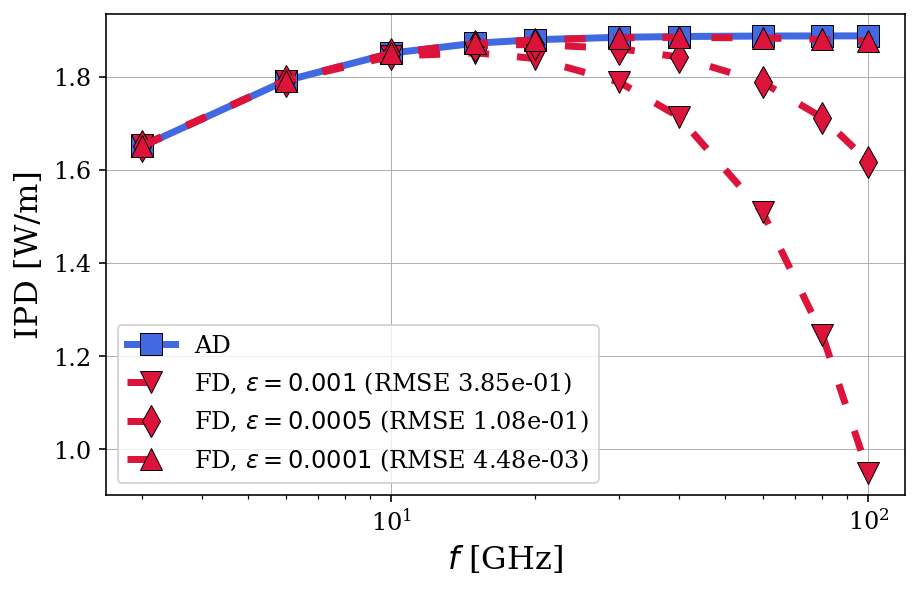

In [45]:
fig_config(scaler=1.5)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(f_list, IPD_ad_list, 's-', color='royalblue',
        label=f'AD')
marker_list = ['v', 'd', '^']
for eps, marker in zip(eps_list, marker_list):
    ax.plot(f_list, IPD_fd_dict[eps], '-', dashes=(3, 4),
            marker=marker,
            color='crimson',
            label=f'FD, $\\epsilon = {eps}$ (RMSE {RMSE_dict[eps]:.2e})')
ax.set_xlabel(r'$f$ [GHz]')
ax.set_ylabel(r'IPD [W/m]')
ax.set_xscale('log')
ax.legend()
ax.grid()
plt.show()

In [46]:
fname = 'fig3'
fig.savefig(os.path.join('figs', f'{fname}.pdf'),
            transparent=True,
            bbox_inches='tight', pad_inches=0.1)